## The Witcher: Character Relationship Network Analysis    

Project to analyze the relationship network between characters in The Witcher book series using Python packages Spacy and Networkx for natural language processing and network graph visualization.  

Using 'Named Entity Recognition' (NER), the texts will be parsed to collect character names that appear within each sentance, ie. ["Geralt", "Yennefer"].  
If two character names appear within 2 sentances, we mark a relationship between them.  
In the last steps, we graph the number of relationships to create the network tree.

Notes:
- character names that appear in each book have been pre-scraped from the web and are located in characters.csv  
- Witcher texts sourced from github.com/dworscak/Witcher .. but credit to author Andrzej Sapkowski


In [85]:
# Sample output from final step -- Try Dragging the Graph!
com_net.show("witcher_communities.html")

In [1]:
import pandas as pd
import numpy as np
import spacy
from spacy import displacy
import networkx as nx

import matplotlib.pyplot as plt

In [ ]:
!python -m spacy download en_core_web_sm

In [4]:
# Load spacy English languague model
NER = spacy.load("en_core_web_sm")

Load in the text files for each book in the series

In [5]:
import os
 
# Get all book files in the data directory
all_books = [b for b in os.scandir('data') if '.txt' in b.name]
all_books

[<DirEntry '1 The Last Wish.txt'>,
 <DirEntry '2 The Sword of Destiny.txt'>,
 <DirEntry '3 Blood of Elves.txt'>,
 <DirEntry '4 Times of Contempt.txt'>,
 <DirEntry '5 Baptism of Fire.txt'>,
 <DirEntry '6 The Tower of the Swallow.txt'>,
 <DirEntry '7 The Lady of the Lake.txt'>,
 <DirEntry '8 something ends something begins.txt'>]

Quick test of Spacy reader to see Entity Recognition output

In [26]:
# Read text, test output
book = all_books[0]
book_text = open(book).read()
book_doc = NER(book_text)

In [27]:
# Visualize identified entities
displacy.render(book_doc[0:500], style="ent", jupyter=True)

Looks good - Now load in all character names from .csv

In [28]:
# Read characters
character_df = pd.read_csv("characters.csv")

In [29]:
# Remove brackets and text within brackets
# Split character names into first_name for simplicity
import re 
character_df['character'] = character_df['character'].apply(lambda x: re.sub("[\(].*?[\)]", "", x)) 
character_df['character_firstname'] = character_df['character'].apply(lambda x: x.split(' ', 1)[0])

In [11]:
# Preview character_df 
pd.set_option('display.max_rows', None)
character_df.head(10)

,book,character,character_firstname
0,Category:Baptism of Fire characters,Adalia,Adalia
1,Category:Baptism of Fire characters,Adela,Adela
2,Category:Baptism of Fire characters,Aen Saevherne,Aen
3,Category:Baptism of Fire characters,Aevenien,Aevenien
4,Category:Baptism of Fire characters,Aglaïs,Aglaïs
5,Category:Baptism of Fire characters,Albrich,Albrich
6,Category:Baptism of Fire characters,Amavet,Amavet
7,Category:Baptism of Fire characters,Angus Bri Cri,Angus
8,Category:Baptism of Fire characters,Anna Kameny,Anna
9,Category:Baptism of Fire characters,Anzelm Aubry,Anzelm


Get named entity list per sentence

In [30]:
sent_entity_df = []

# Loop through sentences, store named entity list for each sentence
for sent in book_doc.sents:
    entity_list = [ent.text for ent in sent.ents]
    sent_entity_df.append({"sentence": sent, "entities": entity_list})
    
sent_entity_df = pd.DataFrame(sent_entity_df)

In [31]:
sent_entity_df.head(20)

,sentence,entities
0,"(ï»¿'Does, she, always, devour, her, victims, ...",[]
1,"(\n\n, ', Come, on, ,, Geralt, ,, it, 'll, be,...",[Geralt]
2,"(Pish, !)",[]
3,"(Devours, ,, takes, a, bite, ,, leaves, aside,...",[]
4,"(She, only, bit, the, head, from, one, ,, gutt...",[]
5,"(Damned, mother's-, !, ', \n\n, ', Careful, ,,...","[Velerad, Ostrit]"
6,"(', Say, what, you, want, about, the, striga, ...",[Adda]
7,"(\n\n, ', Has, anyone, she, 's, attacked, surv...",[]
8,"(The, witcher, asked, ,, apparently, paying, n...",[]
9,"(Segelin, and, Ostrit, looked, at, each, other...","[Segelin, Ostrit]"


In [32]:
# Function to filter out non-character entities
def filter_entity(ent_list, character_df):
    return [ent for ent in ent_list 
            if ent in list(character_df.character) 
            or ent in list(character_df.character_firstname)]

In [17]:
filter_entity(["Geralt", "test", "2"], character_df)

['Geralt']

In [23]:
sent_entity_df['character_entities'] = sent_entity_df['entities'].apply(lambda x: filter_entity(x, character_df))

# Filter out sentences that don't have any character entities
sent_entity_df_filtered = sent_entity_df[sent_entity_df['character_entities'].map(len) > 0]
sent_entity_df_filtered.head(20)

,sentence,entities,character_entities
96,"(Is, there, anything, keeping, you, in, this, ...","[Geralt, Rivia]",[Geralt]
104,"("", \n, "", Borch, ,, "", replied, Geralt, ,, wh...","[Borch, Geralt]",[Geralt]
108,"("", \n, "", There, are, some, ,, "", Geralt, rep...",[Geralt],[Geralt]
140,"("", I, forgot, ,, "", Three, Jackdaws, winked, ...","[Three, Geralt]",[Geralt]
151,"(Geralt, loosened, his, belt, ,, removed, his,...",[Geralt],[Geralt]
157,"("", Do, the, girls, speak, the, common, langua...",[Geralt],[Geralt]
160,"(How, 's, your, soup, ,, Geralt, ?, "", \n, "", ...",[Geralt],[Geralt]
172,"(Yet, there, is, a, certain, principal, underl...",[Geralt],[Geralt]
201,"("", Bad, example, ,, "", interrupted, Geralt, .)","[Bad, Geralt]",[Geralt]
211,"("", I, do, not, hunt, dragons, ,, "", Geralt, r...",[Geralt],[Geralt]


In [ ]:
# Take only first name of characters
sent_entity_df_filtered['character_entities'] = sent_entity_df_filtered['character_entities'].apply(lambda x: [item.split()[0] for item in x])

In [33]:
pd.reset_option('^display.', silent=True)
sent_entity_df_filtered.head(20)

,sentence,entities,character_entities
96,"(Is, there, anything, keeping, you, in, this, ...","[Geralt, Rivia]",[Geralt]
104,"("", \n, "", Borch, ,, "", replied, Geralt, ,, wh...","[Borch, Geralt]",[Geralt]
108,"("", \n, "", There, are, some, ,, "", Geralt, rep...",[Geralt],[Geralt]
140,"("", I, forgot, ,, "", Three, Jackdaws, winked, ...","[Three, Geralt]",[Geralt]
151,"(Geralt, loosened, his, belt, ,, removed, his,...",[Geralt],[Geralt]
157,"("", Do, the, girls, speak, the, common, langua...",[Geralt],[Geralt]
160,"(How, 's, your, soup, ,, Geralt, ?, "", \n, "", ...",[Geralt],[Geralt]
172,"(Yet, there, is, a, certain, principal, underl...",[Geralt],[Geralt]
201,"("", Bad, example, ,, "", interrupted, Geralt, .)","[Bad, Geralt]",[Geralt]
211,"("", I, do, not, hunt, dragons, ,, "", Geralt, r...",[Geralt],[Geralt]


## Create relationships

In [36]:
window_size = 5
relationships = []

for i in range(sent_entity_df_filtered.index[-1]):
    end_i = min(i+5, sent_entity_df_filtered.index[-1])
    char_list = sum((sent_entity_df_filtered.loc[i: end_i].character_entities), [])
    
    # Remove duplicated characters that are next to each other
    char_unique = [char_list[i] for i in range(len(char_list)) 
                   if (i==0) or char_list[i] != char_list[i-1]]
    
    if len(char_unique) > 1:
        for idx, a in enumerate(char_unique[:-1]):
            b = char_unique[idx + 1]
            relationships.append({"source": a, "target": b})

In [37]:
relationship_df = pd.DataFrame(relationships)

In [38]:
# View all rows or first 20 rows as needed
# pd.set_option('display.max_rows', None)
relationship_df.head(20)

,source,target
0,Geralt,Niedamir
1,Geralt,Niedamir
2,Geralt,Niedamir
3,Niedamir,Geralt
4,Niedamir,Geralt
5,Niedamir,Geralt
6,Niedamir,Geralt
7,Niedamir,Geralt
8,Niedamir,Geralt
9,Geralt,Eyck


In [40]:
# Sort the cases with a->b and b->a by alphabetical for future grouping/counting
relationship_df = pd.DataFrame(np.sort(relationship_df.values, axis = 1), columns = relationship_df.columns)
relationship_df.head(20)

,source,target
0,Geralt,Niedamir
1,Geralt,Niedamir
2,Geralt,Niedamir
3,Geralt,Niedamir
4,Geralt,Niedamir
5,Geralt,Niedamir
6,Geralt,Niedamir
7,Geralt,Niedamir
8,Geralt,Niedamir
9,Eyck,Geralt


In [41]:
relationship_df["value"] = 1
relationship_df = relationship_df.groupby(["source","target"], sort=False, as_index=False).sum()

In [42]:
relationship_df.head(20)

,source,target,value
0,Geralt,Niedamir,19
1,Eyck,Geralt,52
2,Dorregaray,Geralt,36
3,Dorregaray,Yennefer,100
4,Geralt,Yarpen,15
5,Gyllenstiern,Niedamir,33
6,Geralt,Kennet,2
7,Dorregaray,Yarpen,8
8,Boholt,Yennefer,66
9,Boholt,Gyllenstiern,19


## Graph analysis and visualization

In [43]:
# Create a graph from a pandas dataframe
G = nx.from_pandas_edgelist(relationship_df, 
                            source = "source", 
                            target = "target", 
                            edge_attr = "value", 
                            create_using = nx.Graph())

#### Graph visualization - Networkx

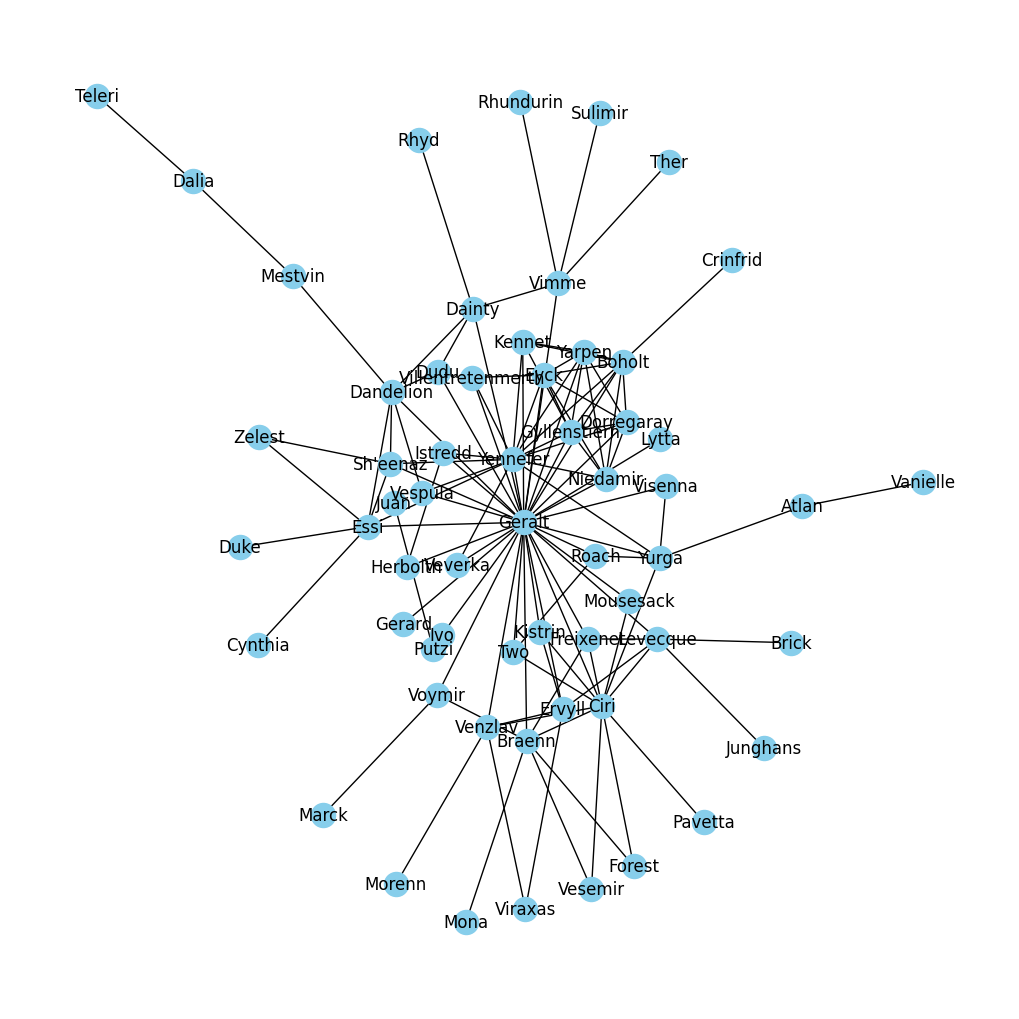

In [44]:
plt.figure(figsize=(10,10))
pos = nx.kamada_kawai_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

# ---> Try Dragging the Graph!

#### Graph visualization - Pyvis

In [59]:
from pyvis.network import Network
from ipython.display import display, HTML, IFrame

In [82]:
net = Network(notebook = True, width="1920px", height="1080px", bgcolor='#222222', font_color='white')
node_degree = dict(G.degree)

#Setting up node size attribute
nx.set_node_attributes(G, node_degree, 'size')

net.from_nx(G)
#net.generate_html()
net.show("witcher.html")

# ---> Try Dragging the Graph!

### The most important characters in The Witcher

In [70]:
# Degree centrality
degree_dict = nx.degree_centrality(G)
degree_dict

{'Geralt': 0.5932203389830508,
 'Niedamir': 0.11864406779661017,
 'Eyck': 0.13559322033898305,
 'Dorregaray': 0.11864406779661017,
 'Yennefer': 0.2542372881355932,
 'Yarpen': 0.13559322033898305,
 'Gyllenstiern': 0.13559322033898305,
 'Kennet': 0.0847457627118644,
 'Boholt': 0.15254237288135594,
 'Crinfrid': 0.01694915254237288,
 'Villentretenmerth': 0.05084745762711865,
 'Istredd': 0.05084745762711865,
 'Herbolth': 0.03389830508474576,
 'Ivo': 0.01694915254237288,
 'Two': 0.05084745762711865,
 'Vespula': 0.05084745762711865,
 'Dainty': 0.0847457627118644,
 'Dandelion': 0.11864406779661017,
 'Rhyd': 0.01694915254237288,
 'Vimme': 0.0847457627118644,
 'Ther': 0.01694915254237288,
 'Sulimir': 0.01694915254237288,
 'Rhundurin': 0.01694915254237288,
 'Dudu': 0.05084745762711865,
 "Sh'eenaz": 0.0847457627118644,
 'Dalia': 0.03389830508474576,
 'Teleri': 0.01694915254237288,
 'Mestvin': 0.03389830508474576,
 'Essi': 0.11864406779661017,
 'Gerard': 0.01694915254237288,
 'Zelest': 0.0338983050

<AxesSubplot:>

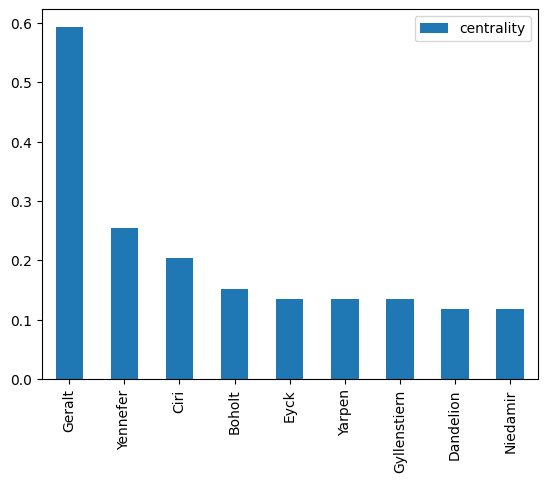

In [71]:
degree_df = pd.DataFrame.from_dict(degree_dict, orient='index', columns=['centrality'])
# Plot top 10 nodes
degree_df.sort_values('centrality', ascending=False)[0:9].plot(kind="bar")

<AxesSubplot:>

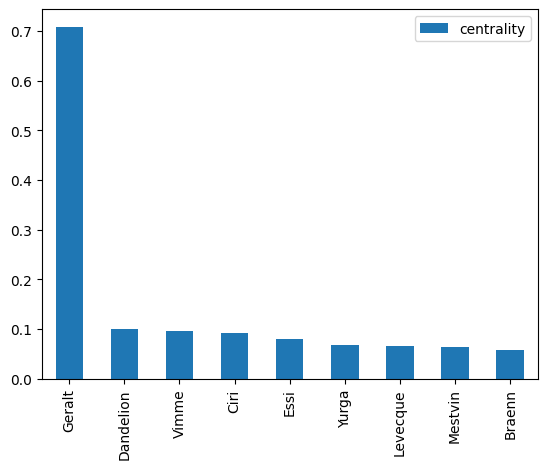

In [72]:
# Betweenness centrality
betweenness_dict = nx.betweenness_centrality(G)
betweenness_df = pd.DataFrame.from_dict(betweenness_dict, orient='index', columns=['centrality'])
# Plot top 10 nodes
betweenness_df.sort_values('centrality', ascending=False)[0:9].plot(kind="bar")

<AxesSubplot:>

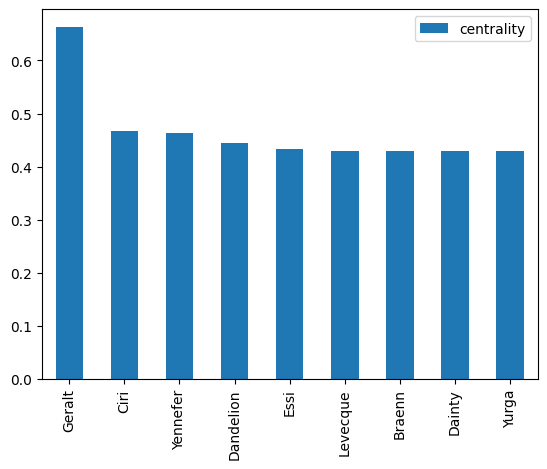

In [73]:
# Closeness centrality
closeness_dict = nx.closeness_centrality(G)
closeness_df = pd.DataFrame.from_dict(closeness_dict, orient='index', columns=['centrality'])
# Plot top 10 nodes
closeness_df.sort_values('centrality', ascending=False)[0:9].plot(kind="bar")

In [74]:
# Save centrality measures
nx.set_node_attributes(G, degree_dict, 'degree_centrality')
nx.set_node_attributes(G, betweenness_dict, 'betweenness_centrality')
nx.set_node_attributes(G, closeness_dict, 'closeness_centrality')

### Community detection

In [76]:
import community as community_louvain

In [77]:
communities = community_louvain.best_partition(G)

In [78]:
communities

{'Geralt': 2,
 'Niedamir': 1,
 'Eyck': 1,
 'Dorregaray': 1,
 'Yennefer': 1,
 'Yarpen': 1,
 'Gyllenstiern': 1,
 'Kennet': 1,
 'Boholt': 1,
 'Crinfrid': 1,
 'Villentretenmerth': 1,
 'Istredd': 2,
 'Herbolth': 2,
 'Ivo': 2,
 'Two': 2,
 'Vespula': 3,
 'Dainty': 3,
 'Dandelion': 3,
 'Rhyd': 3,
 'Vimme': 3,
 'Ther': 3,
 'Sulimir': 3,
 'Rhundurin': 3,
 'Dudu': 3,
 "Sh'eenaz": 3,
 'Dalia': 3,
 'Teleri': 3,
 'Mestvin': 3,
 'Essi': 3,
 'Gerard': 2,
 'Zelest': 3,
 'Duke': 3,
 'Veverka': 2,
 'Juan': 4,
 'Putzi': 4,
 'Cynthia': 3,
 'Braenn': 0,
 'Ciri': 0,
 'Marck': 0,
 'Voymir': 0,
 'Ervyll': 0,
 'Kistrin': 0,
 'Vesemir': 0,
 'Freixenet': 0,
 'Venzlav': 0,
 'Viraxas': 0,
 'Morenn': 0,
 'Mona': 0,
 'Forest': 0,
 'Pavetta': 0,
 'Levecque': 0,
 'Junghans': 0,
 'Brick': 0,
 'Mousesack': 0,
 'Yurga': 2,
 'Visenna': 2,
 'Atlan': 2,
 'Vanielle': 2,
 'Lytta': 2,
 'Roach': 2}

In [79]:
nx.set_node_attributes(G, communities, 'group')

In [81]:
com_net = Network(notebook = True, width="1920px", height="1080px", bgcolor='#222222', font_color='white')
com_net.from_nx(G)
com_net.show("witcher_communities.html")

### Evolution of characters' importance

In [5]:
from lib.utils.functions import *

In [6]:
# Initialize empty list for graphs from books
books_graph = []
all_books = [b for b in os.scandir('data') if '.txt' in b.name]
# Load spacy English languague model
nlp = spacy.load("en_core_web_sm")

# Sort dir entries by name
all_books.sort(key=lambda x: x.name)

In [ ]:
# Loop through book list and create graphs
for book in all_books:
    book_text = ner(book)
    
    # Get list of entities per sentences
    sent_entity_df = get_ne_list_per_sentence(book_text)
    
    # Select only character entities
    sent_entity_df['character_entities'] = sent_entity_df['entities'].apply(lambda x: filter_entity(x, character_df))

    # Filter out sentences that don't have any character entities
    sent_entity_df_filtered = sent_entity_df[sent_entity_df['character_entities'].map(len) > 0]
    
    # Take only first name of characters
    sent_entity_df_filtered['character_entities'] = sent_entity_df_filtered['character_entities'].apply(lambda x: [item.split()[0] 
                                                                                                               for item in x])

    # Create relationship df
    relationship_df = create_relationships(df = sent_entity_df_filtered, window_size = 5)                                                                                                               
    
    # Create a graph from a pandas dataframe
    G = nx.from_pandas_edgelist(relationship_df, 
                                source = "source", 
                                target = "target", 
                                edge_attr = "value", 
                                create_using = nx.Graph())     
    
    books_graph.append(G) 

<AxesSubplot:>

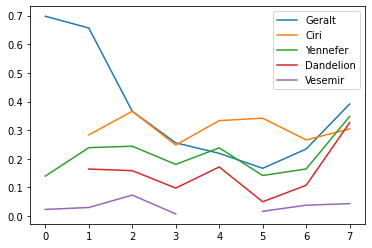

In [8]:
# Creating a list of degree centrality of all the books
evol = [nx.degree_centrality(book) for book in books_graph]

# Creating a DataFrame from the list of degree centralities in all the books
degree_evol_df = pd.DataFrame.from_records(evol)

# Plotting the degree centrality evolution of 5 main characters
degree_evol_df[["Geralt", "Ciri", "Yennefer", "Dandelion", "Vesemir"]].plot()